# This notebook was prepared by the team: Aysel Mirzoeva and Borisiuk Anna

# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [1]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-curand-cu12 10.3.9.90 which is incompatible.


In [ ]:
# Install required libraries
!pip install wandb timm wavemix -q

# Core imports
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
import timm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
from datasets import load_dataset
import wandb

# Evaluation imports
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Special model
from wavemix.classification import WaveMix

In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

(…)-00000-of-00005-3ac4e3b3fa8df68d.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00001-of-00005-72e716d68bb13413.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00002-of-00005-8dd97810f77d7a20.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00003-of-00005-0e1eda89906f6ebb.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

(…)-00004-of-00005-cbbd007c0641d389.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

(…)-00000-of-00001-cef82967b9d8e57e.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1774 [00:00<?, ? examples/s]


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


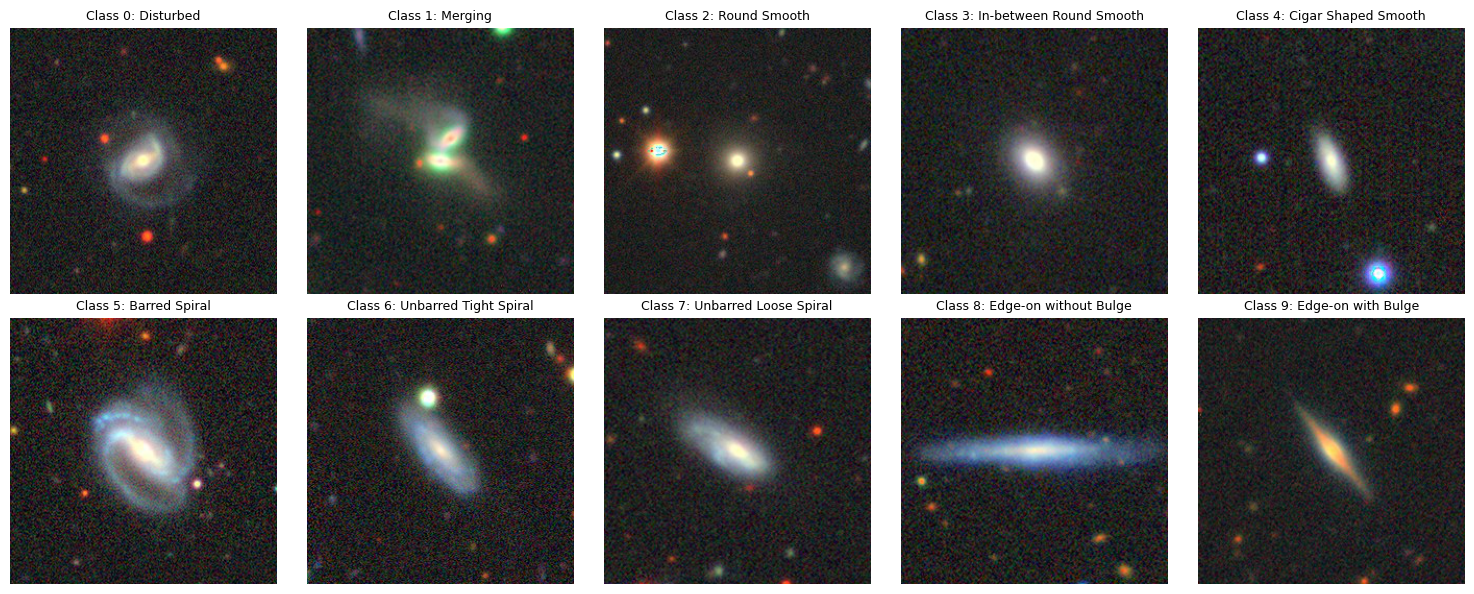

In [5]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

The Galaxy10 dataset presents several challenges that can negatively affect classification performance: overlapping classes (e.g., "Barred Spiral" and "Unbarred Spiral" are difficult to distinguish), strong orientation dependence for some types (e.g., "Edge-on" galaxies), scale variations of objects, class imbalance (many "Round Smooth" galaxies and few "Disturbed" ones), background noise and artifacts, as well as labeling errors or ambiguities (e.g., "In-between Round Smooth"). To improve quality, careful application of augmentations (especially rotations and crops), proper normalization, and strong regularization are required.

# Training

**Part1.** In this series of experiments, we worked with EfficientNet-B4, EfficientNet-B0, WaveMix, and tuned their training parameters (learning rate, number of epochs) as well as augmentations (rotations, crops, normalization, etc.). Unfortunately, not all setups were preserved in the code, since at that time the assignment only accepted models with accuracy greater than 90%. However, we are **attaching the wandb logs** as evidence(but unfortunately the first experiments were conducted without logging). <br>
**The second part of the series of experiments of this notebook will also be separately attached.** This is because we didn't want to make the notebook too long, and we also ran it on different free platforms due to limited resources (kaggle and colab).

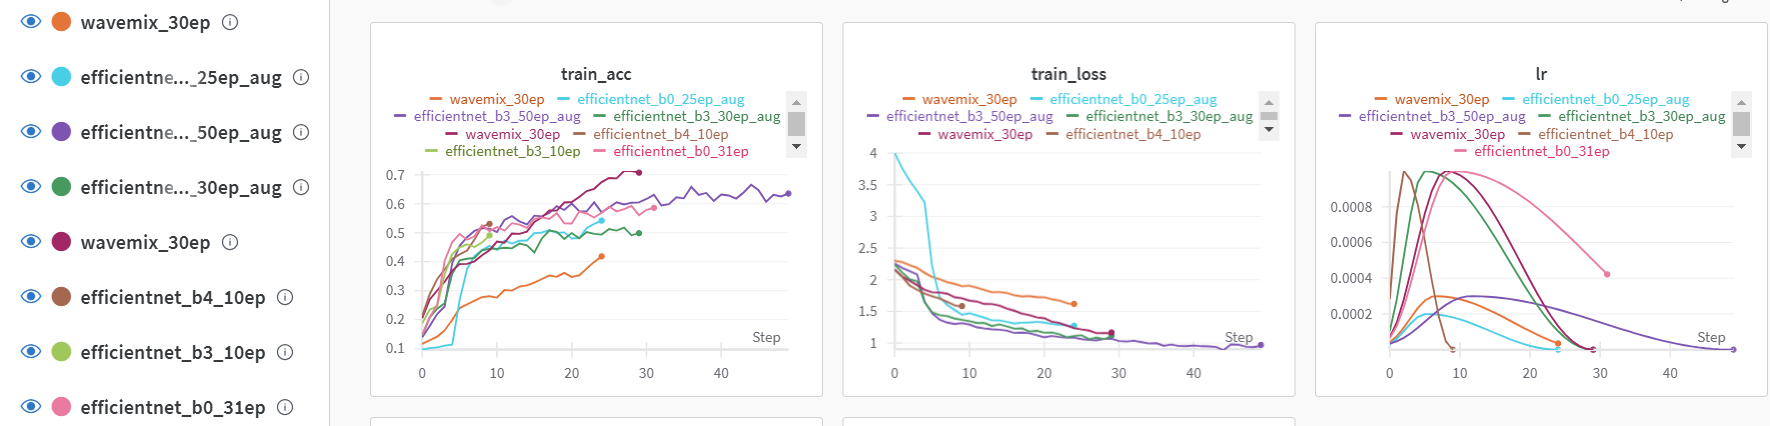

The graphs show that all architectures were successfully trained and did not diverge, but the models still tended to overtrain quickly. This is evidenced by the high quality on the track (~90-98) and low quality on the test (~80-85). For example, the first run of wavemix was quite fast in increasing accuracy and falling in loss, but the output was one of the smallest accuracy, then on the second run we slightly reduced lr, but the model lost a lot in quality, so we did early stopping, realizing from the trend of the graph that it began to learn much worse and slower than other algorithms 

To avoid overtraining we reduced lr, experimented with augmentation and tried simpler architectures including creating our own architecture from scratch on convolutions and vit.

In [5]:
!pip install wandb wavemix -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 850.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [8]:
import os
import wandb

wandb.login(key="01209f6898e0b2cfc297ddbdc5fb043af319271c")  # try to log wandb, case 1

os.environ["WANDB_API_KEY"] = "01209f6898e0b2cfc297ddbdc5fb043af319271c" # or this case 2
wandb.login()

wandb.init(project="galaxy10_classification")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## EfficientNet-B4 50 ephs

In [10]:
# Hyperparameters (local dict)
params = {
    "seed":            42,
    "model_name":      "efficientnet_b3",
    "batch_size":      32,
    "epochs":          50,
    "img_size":        224, # with this img size the model worked more stable (related to the architecture)
    "lr_max":          3e-4,
    "weight_decay":    1e-4,
    "mixup_alpha":     0.2,
    "cutmix_prob":     0.5,
    "label_smoothing": 0.1,
    "div_factor":      10,
    "final_div_factor":100,
    "pct_start":       0.25
}

# wandb conf
wandb.init(project="galaxy10_classification", config=params)

cfg = wandb.config
seed            = params["seed"]
model_name      = params["model_name"]
batch_size      = params["batch_size"]
epochs          = params["epochs"]
img_size        = params["img_size"]
lr_max          = params["lr_max"]
weight_decay    = params["weight_decay"]
mixup_alpha     = params["mixup_alpha"]
cutmix_prob     = params["cutmix_prob"]
label_smoothing = params["label_smoothing"]
div_factor      = params["div_factor"]
final_div_factor= params["final_div_factor"]
pct_start       = params["pct_start"]

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Transforms
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_tf = T.Compose([
    T.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    T.RandAugment(num_ops=2, magnitude=10),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomErasing(p=0.2)
])

# Load TRAIN split
dataset = load_dataset("matthieulel/galaxy10_decals")
train_ds = dataset["train"]

# Dataset wrapper
class GalaxyDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.tf = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return self.tf(img), ex["label"]

train_loader = DataLoader(
    GalaxyDataset(train_ds, train_tf),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# MixUp and CutMix functions
def mixup_data(x, y, alpha):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam

def cutmix_data(x, y, alpha, prob):
    if alpha <= 0 or random.random() > prob:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    _, _, H, W = x.size()
    cut_rat = np.sqrt(1 - lam)
    cw, ch = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = max(cx - cw//2, 0), max(cy - ch//2, 0)
    x2, y2 = min(cx + cw//2, W), min(cy + ch//2, H)
    idx = torch.randperm(x.size(0))
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adj = 1 - ((x2-x1)*(y2-y1)/(W*H))
    return x, y, y[idx], lam_adj

# Build model, freeze backbone, replace head
model = getattr(models, model_name)(pretrained=True)
for p in model.features.parameters():
    p.requires_grad = False
nf = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(nf, 10)
)
model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer = optim.AdamW(
    model.parameters(),
    lr=lr_max,
    weight_decay=weight_decay
)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr_max,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=pct_start,
    div_factor=div_factor,
    final_div_factor=final_div_factor
)

wandb.watch(model, log="all", log_freq=200)

# Training loop
model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    epoch_corr = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        # unfreeze after 4 epochs
        if epoch == 5:
            for p in model.features.parameters():
                p.requires_grad = True

        # apply MixUp or CutMix
        if random.random() < cutmix_prob:
            x_mix, y_a, y_b, lam = cutmix_data(imgs, labels, mixup_alpha, cutmix_prob)
        else:
            x_mix, y_a, y_b, lam = mixup_data(imgs, labels, mixup_alpha)

        optimizer.zero_grad()
        out = model(x_mix)
        loss = lam*criterion(out, y_a) + (1-lam)*criterion(out, y_b)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item() * imgs.size(0)
        epoch_corr += (out.argmax(1)==labels).sum().item()

    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc  = epoch_corr / len(train_loader.dataset)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "lr": scheduler.get_last_lr()[0]
    })
    print(f"Epoch {epoch}: loss={train_loss:.4f}, acc={train_acc:.4f}")

# Save final model
torch.save(model.state_dict(), "best_mixup_cutmix.pth")
wandb.save("best_mixup_cutmix.pth")
wandb.finish()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 173MB/s]
Epoch 1/50: 100%|██████████| 499/499 [01:26<00:00,  5.78it/s]


Epoch 1: loss=2.2635, acc=0.1391


Epoch 2/50: 100%|██████████| 499/499 [01:22<00:00,  6.08it/s]


Epoch 2: loss=2.1964, acc=0.1780


Epoch 3/50: 100%|██████████| 499/499 [01:20<00:00,  6.19it/s]


Epoch 3: loss=2.1439, acc=0.2195


Epoch 4/50: 100%|██████████| 499/499 [01:26<00:00,  5.77it/s]


Epoch 4: loss=2.0928, acc=0.2455


Epoch 5/50: 100%|██████████| 499/499 [02:43<00:00,  3.05it/s]


Epoch 5: loss=1.6652, acc=0.3941


Epoch 6/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 6: loss=1.4822, acc=0.4550


Epoch 7/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 7: loss=1.3804, acc=0.4844


Epoch 8/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 8: loss=1.3365, acc=0.5066


Epoch 9/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 9: loss=1.3127, acc=0.5158


Epoch 10/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 10: loss=1.3271, acc=0.5141


Epoch 11/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 11: loss=1.3053, acc=0.5023


Epoch 12/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 12: loss=1.2612, acc=0.5443


Epoch 13/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 13: loss=1.2442, acc=0.5574


Epoch 14/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 14: loss=1.2304, acc=0.5393


Epoch 15/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 15: loss=1.2247, acc=0.5284


Epoch 16/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 16: loss=1.2098, acc=0.5590


Epoch 17/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 17: loss=1.1732, acc=0.5564


Epoch 18/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 18: loss=1.1799, acc=0.5686


Epoch 19/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 19: loss=1.1690, acc=0.5918


Epoch 20/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 20: loss=1.1381, acc=0.5785


Epoch 21/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 21: loss=1.1054, acc=0.6006


Epoch 22/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 22: loss=1.1250, acc=0.5746


Epoch 23/50: 100%|██████████| 499/499 [02:39<00:00,  3.14it/s]


Epoch 23: loss=1.1107, acc=0.5735


Epoch 24/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 24: loss=1.1000, acc=0.6047


Epoch 25/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 25: loss=1.0978, acc=0.5702


Epoch 26/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 26: loss=1.0767, acc=0.5869


Epoch 27/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 27: loss=1.0630, acc=0.6050


Epoch 28/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 28: loss=1.0569, acc=0.5975


Epoch 29/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 29: loss=1.0793, acc=0.6036


Epoch 30/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 30: loss=1.0813, acc=0.6049


Epoch 31/50: 100%|██████████| 499/499 [02:39<00:00,  3.14it/s]


Epoch 31: loss=1.0467, acc=0.6165


Epoch 32/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 32: loss=1.0396, acc=0.6308


Epoch 33/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 33: loss=1.0514, acc=0.5940


Epoch 34/50: 100%|██████████| 499/499 [02:39<00:00,  3.14it/s]


Epoch 34: loss=1.0299, acc=0.5989


Epoch 35/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 35: loss=1.0068, acc=0.6226


Epoch 36/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 36: loss=1.0128, acc=0.6187


Epoch 37/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 37: loss=0.9702, acc=0.6584


Epoch 38/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 38: loss=0.9917, acc=0.6302


Epoch 39/50: 100%|██████████| 499/499 [02:39<00:00,  3.14it/s]


Epoch 39: loss=0.9674, acc=0.6373


Epoch 40/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 40: loss=0.9663, acc=0.6095


Epoch 41/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 41: loss=0.9758, acc=0.6319


Epoch 42/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 42: loss=0.9651, acc=0.6287


Epoch 43/50: 100%|██████████| 499/499 [02:39<00:00,  3.14it/s]


Epoch 43: loss=0.9612, acc=0.6178


Epoch 44/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 44: loss=0.9515, acc=0.6391


Epoch 45/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 45: loss=0.9030, acc=0.6656


Epoch 46/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 46: loss=0.9940, acc=0.6468


Epoch 47/50: 100%|██████████| 499/499 [02:38<00:00,  3.14it/s]


Epoch 47: loss=0.9878, acc=0.6071


Epoch 48/50: 100%|██████████| 499/499 [02:38<00:00,  3.15it/s]


Epoch 48: loss=0.9560, acc=0.6307


Epoch 49/50: 100%|██████████| 499/499 [02:39<00:00,  3.13it/s]


Epoch 49: loss=0.9500, acc=0.6252


Epoch 50/50: 100%|██████████| 499/499 [02:39<00:00,  3.14it/s]


Epoch 50: loss=0.9707, acc=0.6352


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
lr,▂▂▃▃▄▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
train_acc,▁▂▂▂▄▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇█████▇█
train_loss,██▇▇▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,50
lr,0.0
train_acc,0.6352
train_loss,0.97068


# Evaluation

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/1793206254.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio

Accuracy:      84.95%
Precision:     84.64%
Recall:        84.95%
F1-score:      84.66%

Per-class metrics:
 0 Disturbed                  P=0.65  R=0.47  F1=0.55  N=109
 1 Merging                    P=0.92  R=0.89  F1=0.90  N=185
 2 Round Smooth               P=0.89  R=0.95  F1=0.92  N=250
 3 In-between Round Smooth    P=0.89  R=0.93  F1=0.91  N=198
 4 Cigar Shaped Smooth        P=0.73  R=0.68  F1=0.70  N=28
 5 Barred Spiral              P=0.86  R=0.83  F1=0.85  N=217
 6 Unbarred Tight Spiral      P=0.75  R=0.80  F1=0.77  N=179
 7 Unbarred Loose Spiral      P=0.77  R=0.78  F1=0.77  N=273
 8 Edge-on without Bulge      P=0.94  R=0.92  F1=0.93  N=157
 9 Edge-on with Bulge         P=0.91  R=0.95  F1=0.93  N=178


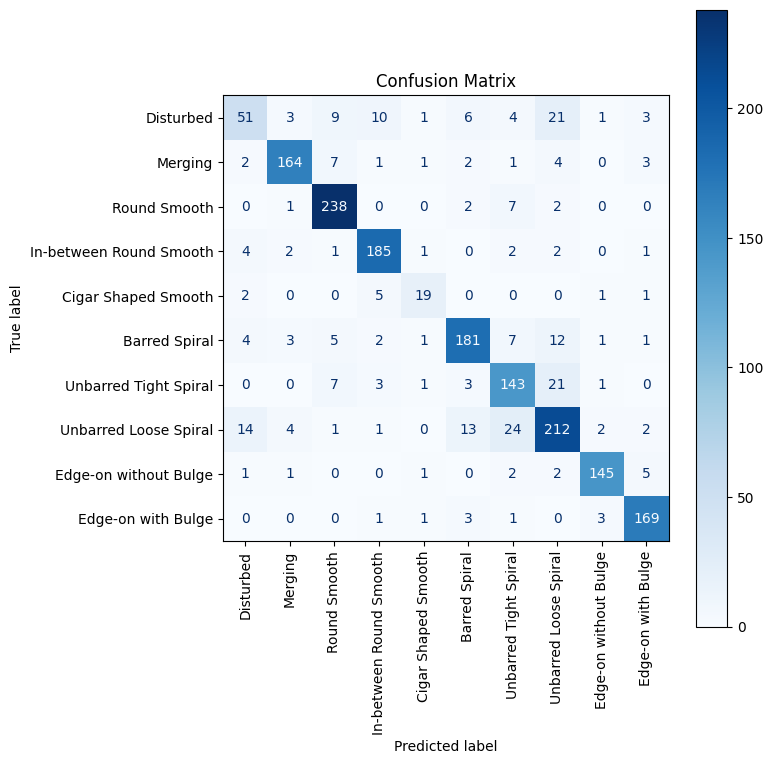

In [13]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    predicted = np.array(predicted_labels)
    true      = np.array(true_labels)
    acc = accuracy_score(true, predicted)
    prec, rec, f1, _ = precision_recall_fscore_support(true, predicted,
                                                       average='weighted',
                                                       zero_division=0)
    cm = confusion_matrix(true, predicted, labels=range(len(class_names_list)))
    print(f"Accuracy:      {acc*100:.2f}%")
    print(f"Precision:     {prec*100:.2f}%")
    print(f"Recall:        {rec*100:.2f}%")
    print(f"F1-score:      {f1*100:.2f}%\n")
    print("Per-class metrics:")
    for i, name in enumerate(class_names_list):
        p, r, f, s = precision_recall_fscore_support(true, predicted,
                                                     labels=[i],
                                                     zero_division=0,
                                                     average=None)[0][0],\
                     precision_recall_fscore_support(true, predicted,
                                                     labels=[i],
                                                     zero_division=0,
                                                     average=None)[1][0],\
                     precision_recall_fscore_support(true, predicted,
                                                     labels=[i],
                                                     zero_division=0,
                                                     average=None)[2][0],\
                     np.bincount(true)[i]
        print(f"{i:>2} {name:<25}  P={p:.2f}  R={r:.2f}  F1={f:.2f}  N={s}")
    # plot CM
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names_list)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return {
        'accuracy': acc,
        'precision_weighted': prec,
        'recall_weighted': rec,
        'f1_weighted': f1,
        'confusion_matrix': cm
    }

IMG_SIZE = 224
BATCH_SIZE = 32
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean, std),
])

class GalaxyDatasetEval(Dataset):
    def __init__(self, hf_ds, tf):
        self.ds = hf_ds
        self.tf = tf
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return self.tf(img), ex["label"]

dataset = load_dataset("matthieulel/galaxy10_decals")
test_ds = dataset["test"]
test_loader = DataLoader(
    GalaxyDatasetEval(test_ds, val_tf),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = getattr(models, params["model_name"])(pretrained=False)
nf = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(nf, 10)
)
model.load_state_dict(torch.load("best_mixup_cutmix.pth", map_location=device))
model.to(device).eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels)

class_names = [
    "Disturbed","Merging","Round Smooth","In-between Round Smooth",
    "Cigar Shaped Smooth","Barred Spiral","Unbarred Tight Spiral",
    "Unbarred Loose Spiral","Edge-on without Bulge","Edge-on with Bulge"
]
metrics = evaluate_predictions(all_preds, all_labels, class_names)

## EfficientNet-B0 25 ephs
- We switched to EfficientNet-B0 for faster training.
- Used class-balanced sampler to address label imbalance.
- Replaced RandAugment+AutoAugment for stronger, varied augmentation.
- Lowered peak learning rate (2e-4) and reduced weight decay.
- Mixed in CutMix and MixUp (α=0.2) per batch.
- Froze backbone for first 5 epochs, then fine-tuned full network.
- OneCycleLR with gentler warm-up (pct_start=0.25) and shallower decay (div_factor=10).

In [14]:
# Hyperparameters
params = {
    "seed":            42,
    "model_name":      "efficientnet_b0",
    "batch_size":      64,
    "epochs":          25,
    "img_size":        224,
    "lr":              2e-4,
    "weight_decay":    1e-5,
    "mixup_alpha":     0.2,
    "cutmix_prob":     0.5,
    "label_smoothing": 0.1,
    "div_factor":      10,
    "final_div_factor":100,
    "pct_start":       0.25,
    "rand_erasing_p":  0.2
}

wandb.init(project="galaxy10_classification", config=params)
cfg = wandb.config

torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Transforms
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
train_tf = T.Compose([
    T.RandomResizedCrop(cfg.img_size, scale=(0.8,1.0)),
    T.AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.3,0.3,0.3,0.1),
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomErasing(p=cfg.rand_erasing_p)
])

# Load TRAIN split & balanced sampler
ds = load_dataset("matthieulel/galaxy10_decals")["train"]
labels = np.array(ds["label"])
class_counts = np.bincount(labels, minlength=10)
class_weights = 1.0 / class_counts
sample_weights = class_weights[labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Dataset & DataLoader
class GalaxyDataset(Dataset):
    def __init__(self, hf_ds, tf):
        self.ds = hf_ds
        self.tf = tf
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return self.tf(img), ex["label"]

train_loader = DataLoader(
    GalaxyDataset(ds, train_tf),
    batch_size=cfg.batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

# MixUp & CutMix functions
def mixup_data(x, y, alpha):
    lam = np.random.beta(alpha, alpha) if alpha>0 else 1.0
    idx = torch.randperm(x.size(0))
    mixed_x = lam*x + (1-lam)*x[idx]
    return mixed_x, y, y[idx], lam

def cutmix_data(x, y, alpha, prob):
    if random.random() > prob or alpha<=0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    _, _, H, W = x.size()
    cut_rat = np.sqrt(1-lam)
    cw, ch = int(W*cut_rat), int(H*cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = max(cx-cw//2,0), max(cy-ch//2,0)
    x2, y2 = min(cx+cw//2,W), min(cy+ch//2,H)
    idx = torch.randperm(x.size(0))
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adj = 1 - ((x2-x1)*(y2-y1)/(W*H))
    return x, y, y[idx], lam_adj

# Build model, freeze backbone initially
model = timm.create_model(cfg.model_name, pretrained=True, num_classes=10)
for p in model.parameters():
    p.requires_grad = False
# only head trainable
for p in model.get_classifier().parameters():
    p.requires_grad = True
model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=cfg.lr,
    steps_per_epoch=len(train_loader),
    epochs=cfg.epochs,
    pct_start=cfg.pct_start,
    div_factor=cfg.div_factor,
    final_div_factor=cfg.final_div_factor
)

wandb.watch(model, log="all", log_freq=200)

# Training loop
model.train()
for epoch in range(1, cfg.epochs+1):
    # unfreeze backbone after 5 epochs
    if epoch == 6:
        for p in model.parameters():
            p.requires_grad = True

    total_loss = 0.0
    total_corr = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        # MixUp or CutMix
        if random.random() < cfg.cutmix_prob:
            x_mix, y_a, y_b, lam = cutmix_data(imgs, labels, cfg.mixup_alpha, cfg.cutmix_prob)
        else:
            x_mix, y_a, y_b, lam = mixup_data(imgs, labels, cfg.mixup_alpha)

        optimizer.zero_grad()
        logits = model(x_mix)
        loss = lam*criterion(logits, y_a) + (1-lam)*criterion(logits, y_b)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * imgs.size(0)
        total_corr += (logits.argmax(1)==labels).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = total_corr / len(train_loader.dataset)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "lr": scheduler.get_last_lr()[0]
    })
    print(f"Epoch {epoch}: loss={train_loss:.4f}, acc={train_acc:.4f}")



torch.save(model.state_dict(), "efficientnet_b0_mixup_cutmix.pth")
wandb.save("efficientnet_b0_mixup_cutmix.pth")
wandb.finish()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 250/250 [01:19<00:00,  3.13it/s]


Epoch 1: loss=4.0007, acc=0.0960


Epoch 2/25: 100%|██████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 2: loss=3.7597, acc=0.1015


Epoch 3/25: 100%|██████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 3: loss=3.5613, acc=0.1042


Epoch 4/25: 100%|██████████| 250/250 [01:19<00:00,  3.16it/s]


Epoch 4: loss=3.4011, acc=0.1101


Epoch 5/25: 100%|██████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 5: loss=3.2259, acc=0.1135


Epoch 6/25: 100%|██████████| 250/250 [01:31<00:00,  2.74it/s]


Epoch 6: loss=2.2189, acc=0.2679


Epoch 7/25: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 7: loss=1.7379, acc=0.3753


Epoch 8/25: 100%|██████████| 250/250 [01:31<00:00,  2.72it/s]


Epoch 8: loss=1.6135, acc=0.4196


Epoch 9/25: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s]


Epoch 9: loss=1.5362, acc=0.4405


Epoch 10/25: 100%|██████████| 250/250 [01:33<00:00,  2.68it/s]


Epoch 10: loss=1.4607, acc=0.4544


Epoch 11/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 11: loss=1.4827, acc=0.4404


Epoch 12/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 12: loss=1.4476, acc=0.4726


Epoch 13/25: 100%|██████████| 250/250 [01:28<00:00,  2.81it/s]


Epoch 13: loss=1.4118, acc=0.4625


Epoch 14/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 14: loss=1.3699, acc=0.4724


Epoch 15/25: 100%|██████████| 250/250 [01:29<00:00,  2.79it/s]


Epoch 15: loss=1.3711, acc=0.4733


Epoch 16/25: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 16: loss=1.3478, acc=0.4987


Epoch 17/25: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s]


Epoch 17: loss=1.3208, acc=0.5003


Epoch 18/25: 100%|██████████| 250/250 [01:29<00:00,  2.79it/s]


Epoch 18: loss=1.3349, acc=0.5096


Epoch 19/25: 100%|██████████| 250/250 [01:28<00:00,  2.82it/s]


Epoch 19: loss=1.3367, acc=0.4994


Epoch 20/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 20: loss=1.3474, acc=0.5012


Epoch 21/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 21: loss=1.3373, acc=0.4800


Epoch 22/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 22: loss=1.3164, acc=0.4824


Epoch 23/25: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s]


Epoch 23: loss=1.3001, acc=0.5159


Epoch 24/25: 100%|██████████| 250/250 [01:28<00:00,  2.81it/s]


Epoch 24: loss=1.2917, acc=0.5309


Epoch 25/25: 100%|██████████| 250/250 [01:29<00:00,  2.79it/s]

Epoch 25: loss=1.2737, acc=0.5418


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
lr,▂▃▅▆▇████▇▇▇▆▅▅▄▄▃▃▂▂▁▁▁▁
train_acc,▁▁▁▁▁▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇███
train_loss,█▇▇▆▆▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
lr,0.0
train_acc,0.54185
train_loss,1.27372


/tmp/ipykernel_31/1967747147.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("efficientnet_b0_mixup_cutmix.pth", map_location=DEVICE)
Evaluating

Accuracy:      82.07%
Precision:     82.18%
Recall:        82.07%
F1-score:      81.83%

Per-class metrics:
 0 Disturbed                  P=0.55  R=0.49  F1=0.52  N=109
 1 Merging                    P=0.92  R=0.89  F1=0.90  N=185
 2 Round Smooth               P=0.91  R=0.93  F1=0.92  N=250
 3 In-between Round Smooth    P=0.90  R=0.93  F1=0.92  N=198
 4 Cigar Shaped Smooth        P=0.64  R=1.00  F1=0.78  N=28
 5 Barred Spiral              P=0.83  R=0.81  F1=0.82  N=217
 6 Unbarred Tight Spiral      P=0.65  R=0.81  F1=0.72  N=179
 7 Unbarred Loose Spiral      P=0.73  R=0.59  F1=0.65  N=273
 8 Edge-on without Bulge      P=0.91  R=0.96  F1=0.93  N=157
 9 Edge-on with Bulge         P=0.94  R=0.90  F1=0.92  N=178


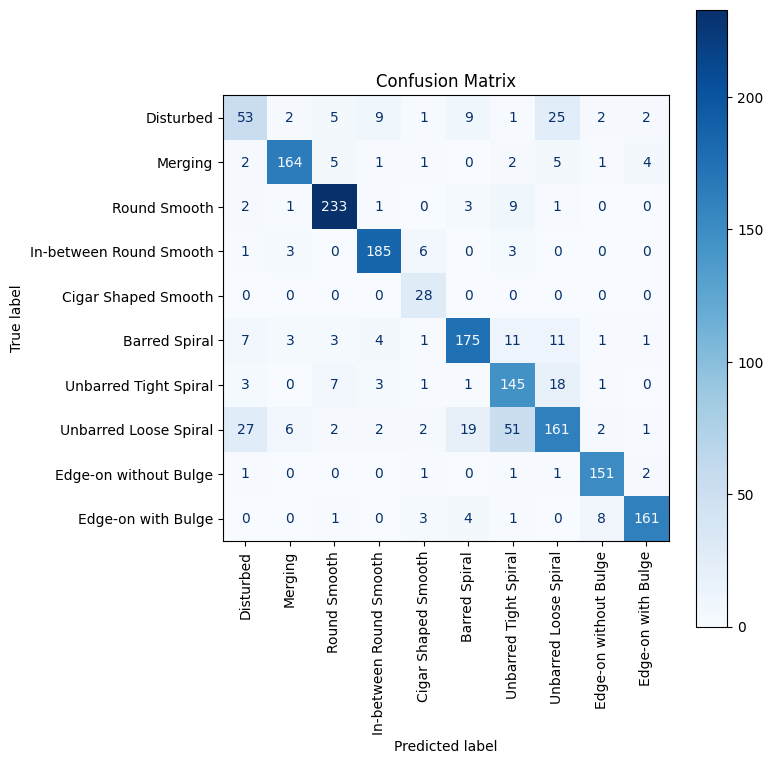

In [15]:
#  Configuration
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE   = params["img_size"]    # 224
BATCH_SIZE = params["batch_size"]  # 64
CLASS_NAMES = [
    "Disturbed","Merging","Round Smooth","In-between Round Smooth",
    "Cigar Shaped Smooth","Barred Spiral","Unbarred Tight Spiral",
    "Unbarred Loose Spiral","Edge-on without Bulge","Edge-on with Bulge"
]

# Test-time transforms
test_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Prepare DataLoader
hf = load_dataset("matthieulel/galaxy10_decals")
test_ds = hf["test"]
test_loader = DataLoader(
    GalaxyDatasetEval(test_ds, test_tf),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Build model and load checkpoint
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=10)
checkpoint = torch.load("efficientnet_b0_mixup_cutmix.pth", map_location=DEVICE)
model.load_state_dict(checkpoint)
model.to(DEVICE).eval()

# Inference
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels)


metrics = evaluate_predictions(all_preds, all_labels, CLASS_NAMES)

## Wavemix 30 ephs

Due to the fact that the required accuracy could not be obtained by any tuning eff_net, we began to look for papers whose models had already been run on galaxy10 and came across wavemix. There the **authors promised 95% accuracy**, but **did not specify at what parameters they obtained this accuracy**. As a result, **it was impossible to reproduce the metrics from the paper... they were less than on eff_net**

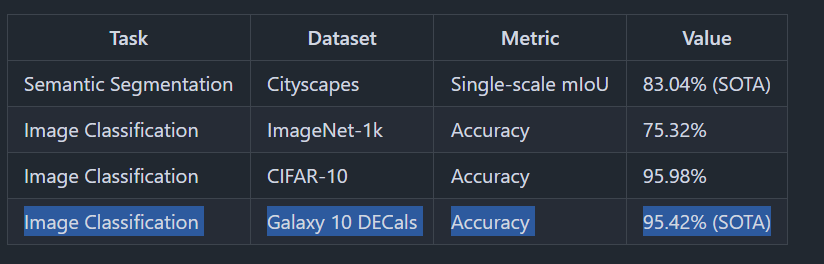

[Paper GitHub Link](https://github.com/pranavphoenix/WaveMix)

In [ ]:
# Hyperparameters
params = {
    "seed":         42,
    "batch_size":   64,
    "epochs":       30,
    "img_size":     224,
    "lr":           3e-4,
    "weight_decay": 1e-5,
    "rand_erasing_p": 0.2,
    "mixup_alpha":  0.2,
    "cutmix_prob":  0.5,
    "div_factor":   10,
    "final_div_factor": 100,
    "pct_start":    0.25
}

wandb.init(project="galaxy10_classification", config=params)
cfg = wandb.config

torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Transforms
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
train_tf = T.Compose([
    T.RandomResizedCrop(cfg.img_size, scale=(0.8,1.0)),
    T.AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomErasing(p=cfg.rand_erasing_p)
])

# Load TRAIN split & class-balanced sampler
ds = load_dataset("matthieulel/galaxy10_decals")["train"]
labels = np.array(ds["label"])
class_counts = np.bincount(labels, minlength=10)
class_weights = 1.0 / class_counts
sample_weights = class_weights[labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 6) Dataset & DataLoader
class GalaxyDataset(Dataset):
    def __init__(self, hf_ds, tf):
        self.ds = hf_ds
        self.tf = tf
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        ex = self.ds[i]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return self.tf(img), ex["label"]

train_loader = DataLoader(
    GalaxyDataset(ds, train_tf),
    batch_size=cfg.batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

# MixUp & CutMix
def mixup_data(x, y, alpha):
    lam = np.random.beta(alpha, alpha) if alpha>0 else 1.0
    idx = torch.randperm(x.size(0))
    return lam*x + (1-lam)*x[idx], y, y[idx], lam

def cutmix_data(x, y, alpha, prob):
    if random.random()>prob:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    _,_,H,W = x.size()
    cut_rat = np.sqrt(1-lam)
    cw, ch = int(W*cut_rat), int(H*cut_rat)
    cx,cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = max(cx-cw//2,0), max(cy-ch//2,0)
    x2, y2 = min(cx+cw//2,W), min(cy+ch//2,H)
    idx = torch.randperm(x.size(0))
    x[:,:,y1:y2,x1:x2] = x[idx,:,y1:y2,x1:x2]
    lam_adj = 1 - ((x2-x1)*(y2-y1)/(W*H))
    return x, y, y[idx], lam_adj

# Build WaveMix model
model = WaveMix(
    num_classes=10,
    depth=12,
    mult=2,
    ff_channel=128,
    final_dim=128,
    dropout=0.5,
    level=3,
    patch_size=4
).to(device)

# Optimizer & scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=cfg.lr,
    epochs=cfg.epochs,
    steps_per_epoch=len(train_loader),
    pct_start=cfg.pct_start,
    div_factor=cfg.div_factor,
    final_div_factor=cfg.final_div_factor
)

wandb.watch(model, log="all", log_freq=200)

# Training loop
model.train()
for epoch in range(1, cfg.epochs+1):
    total_loss = 0.0
    total_corr = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        # apply CutMix or MixUp
        if random.random() < cfg.cutmix_prob:
            x_mix, y_a, y_b, lam = cutmix_data(imgs, labels, cfg.mixup_alpha, cfg.cutmix_prob)
        else:
            x_mix, y_a, y_b, lam = mixup_data(imgs, labels, cfg.mixup_alpha)
        optimizer.zero_grad()
        logits = model(x_mix)
        loss = lam*criterion(logits, y_a) + (1-lam)*criterion(logits, y_b)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * imgs.size(0)
        total_corr += (logits.argmax(1)==labels).sum().item()
    train_loss = total_loss / len(train_loader.dataset)
    train_acc  = total_corr / len(train_loader.dataset)
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "lr": scheduler.get_last_lr()[0]
    })
    print(f"Epoch {epoch}: loss={train_loss:.4f}, acc={train_acc:.4f}")




torch.save(model.state_dict(), "wavemix_30ep.pth")
wandb.save("wavemix_30ep.pth")
wandb.finish()

Epoch 1/30: 100%|██████████| 250/250 [04:46<00:00,  1.15s/it]


Epoch 1: loss=2.3076, acc=0.1164


Epoch 2/30: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]


Epoch 2: loss=2.2852, acc=0.1287


Epoch 3/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 3: loss=2.2379, acc=0.1410


Epoch 4/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 4: loss=2.1945, acc=0.1628


Epoch 5/30: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]


Epoch 5: loss=2.1170, acc=0.1989


Epoch 6/30: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]


Epoch 6: loss=2.0513, acc=0.2400


Epoch 7/30: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]


Epoch 7: loss=2.0158, acc=0.2523


Epoch 8/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 8: loss=1.9693, acc=0.2659


Epoch 9/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 9: loss=1.9446, acc=0.2777


Epoch 10/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 10: loss=1.9073, acc=0.2805


Epoch 11/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 11: loss=1.9143, acc=0.2760


Epoch 12/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 12: loss=1.8849, acc=0.3023


Epoch 13/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 13: loss=1.8494, acc=0.3000


Epoch 14/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 14: loss=1.8135, acc=0.3140


Epoch 15/30: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]


Epoch 15: loss=1.8156, acc=0.3183


Epoch 16/30: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]


Epoch 16: loss=1.7993, acc=0.3277


Epoch 17/30:  65%|██████▌   | 163/250 [02:49<01:30,  1.04s/it]

In [ ]:
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE   = 224
BATCH_SIZE = 64
CLASS_NAMES = [
    "Disturbed","Merging","Round Smooth","In-between Round Smooth",
    "Cigar Shaped Smooth","Barred Spiral","Unbarred Tight Spiral",
    "Unbarred Loose Spiral","Edge-on without Bulge","Edge-on with Bulge"
]

test_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Dataset wrapper
class GalaxyEvalDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.tf = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return self.tf(img), ex["label"]

raw = load_dataset("matthieulel/galaxy10_decals")
test_ds = raw["test"]
test_loader = DataLoader(
    GalaxyEvalDataset(test_ds, test_tf),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Load trained WaveMix checkpoint
from wavemix.classification import WaveMix
import torch.nn as nn

model = WaveMix(
    num_classes=10,
    depth=12,
    mult=2,
    ff_channel=128,
    final_dim=128,
    dropout=0.5,
    level=3,
    patch_size=4
)
model.load_state_dict(torch.load("wavemix_30ep.pth", map_location=DEVICE))
model.to(DEVICE).eval()

# Inference
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels)


metrics = evaluate_predictions(all_preds, all_labels, CLASS_NAMES)